# Setup
--> "Runtime" --> "Change runtime type" --> "GPU" hardware accelerator

## Installs

In [ ]:
! pip install -qU tensorflow_datasets

## Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random as random

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from keras.utils import np_utils

import tensorflow_datasets as tfds

# Eurostat Data

In [ ]:
%%html
<iframe src="https://ec.europa.eu/eurostat/databrowser/view/lan_lcv_ovw/default/table?lang=en" width="1000" height="600"></iframe>

# EuroSAT Dataset
https://www.tensorflow.org/datasets/catalog/eurosat

## Download Data

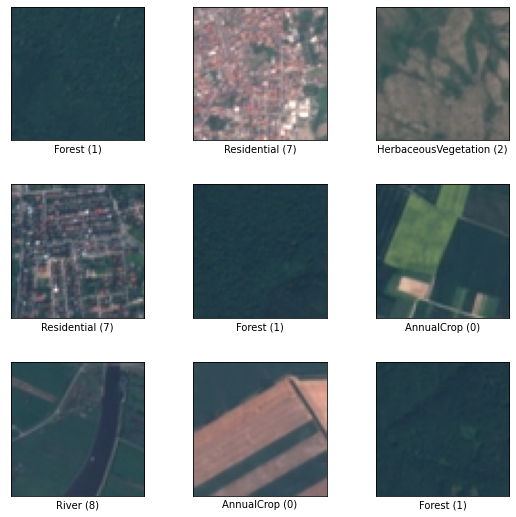

In [ ]:
ds, ds_info = tfds.load('eurosat/rgb',
                        with_info=True,
                        split='train',
                        data_dir='.')

tfds.show_examples(ds, ds_info);

In [ ]:
print(ds_info)

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_path='./eurosat/rgb/2.0.0',
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_sh

## Load into Pandas

In [ ]:
%%time
df = tfds.as_dataframe(ds, ds_info)
print(df.shape)

(27000, 3)
CPU times: user 21.1 s, sys: 2.77 s, total: 23.9 s
Wall time: 20.6 s


In [ ]:
df.sample(5)

,filename,image,label
6668,b'SeaLake_2289.jpg',"[[[30, 56, 79], [31, 57, 80], [31, 59, 80], [2...",9
17362,b'Forest_1788.jpg',"[[[51, 77, 90], [51, 77, 90], [50, 76, 89], [5...",1
15902,b'Pasture_1994.jpg',"[[[69, 99, 87], [70, 98, 86], [75, 98, 92], [8...",5
22839,b'Pasture_1776.jpg',"[[[37, 76, 75], [40, 74, 75], [56, 81, 85], [6...",5
16098,b'Pasture_1412.jpg',"[[[44, 89, 82], [44, 89, 82], [42, 89, 81], [4...",5


## Target Distribution

In [ ]:
df.groupby('label')['label'].value_counts()

label  label
0      0        3000
1      1        3000
2      2        3000
3      3        2500
4      4        2500
5      5        2000
6      6        2500
7      7        3000
8      8        2500
9      9        3000
Name: label, dtype: int64

## Image Dimensions

In [ ]:
df['image'][0].shape

(64, 64, 3)

## Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.stack(df['image'].values),
                                                    np.stack(df['label'].values), 
                                                    test_size=0.333333, 
                                                    shuffle=True,
                                                    random_state=10)
print('Train: ', X_train.shape, y_train.shape)
print('Test: ', X_test.shape, y_test.shape)

Train:  (18000, 64, 64, 3) (18000,)
Test:  (9000, 64, 64, 3) (9000,)


## OneHot Encode the Label

In [ ]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

In [ ]:
print(y_train.shape, y_test.shape)
print(y_train[:4])

(18000, 10) (9000, 10)
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


# MLP

## Reshape & Scale

In [ ]:
num_pixels = int(np.prod(X_train.shape[1:]))
X_train_mlp = X_train.reshape(X_train.shape[0], num_pixels).astype('float32') / 255
X_test_mlp = X_test.reshape(X_test.shape[0], num_pixels).astype('float32') / 255

print('Train: ', X_train_mlp.shape, y_train.shape)
print('Test: ', X_test_mlp.shape, y_test.shape)

Train:  (18000, 12288) (18000, 10)
Test:  (9000, 12288) (9000, 10)


## Build Model

In [ ]:
def mlp_model():
  model = keras.Sequential([
   layers.Dense(num_pixels, 
                input_dim=num_pixels,
                kernel_initializer='normal',
                activation='relu'),
    layers.Dense(num_classes,
                 kernel_initializer='normal', 
                 activation='softmax')])
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
model = mlp_model()
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 12288)             151007232 
_________________________________________________________________
dense_3 (Dense)              (None, 10)                122890    
Total params: 151,130,122
Trainable params: 151,130,122
Non-trainable params: 0
_________________________________________________________________
None


❓ What do you think of this approach?

# Custom CNN

## Build Model

In [ ]:
def cnn():
  model = keras.Sequential([
    layers.BatchNormalization(input_shape=X_train[0].shape, name='norm_1'),
    layers.Conv2D(16, (5, 5), padding='same', activation='relu', name='conv_1'),
    layers.MaxPool2D(name='pool_1'),
    
    layers.BatchNormalization(name='norm_2'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', name='conv_2_a'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', name='conv_2_b'),
    layers.MaxPool2D(name='pool_2'),
    
    layers.BatchNormalization(name='norm_3'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='conv_3_a'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='conv_3_b'),
    layers.MaxPool2D(name='pool_3'),
    
    layers.Flatten(name='flatten'),
    layers.Dense(128, activation='relu', name='dense_1'),
    layers.Dropout(0.5, name='drop_1'),
    layers.Dense(64, activation='relu', name='dense_2'),
    layers.Dropout(0.5, name='drop_2'),
    layers.Dense(10, activation='softmax', name='output')])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
model = cnn()
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
norm_1 (BatchNormalization)  (None, 64, 64, 3)         12        
_________________________________________________________________
conv_1 (Conv2D)              (None, 64, 64, 16)        1216      
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 32, 32, 16)        0         
_________________________________________________________________
norm_2 (BatchNormalization)  (None, 32, 32, 16)        64        
_________________________________________________________________
conv_2_a (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
conv_2_b (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 16, 16, 32)       

❓ What do you think of this approach?

## Train Model

In [ ]:
%%time
model = cnn()

early_stopping = callbacks.EarlyStopping(
    min_delta=0,
    patience=10,
    restore_best_weights=True,
)

history = model.fit(
    X_train,
    y_train,
    validation_split=0.15,
    epochs=100,
    batch_size=512,
    verbose=1,
    callbacks=[early_stopping])

Epoch 1/100
30/30 [==============================] - 3s 57ms/step - loss: 1.9714 - accuracy: 0.2854 - val_loss: 2.4268 - val_accuracy: 0.0967
Epoch 2/100
30/30 [==============================] - 1s 45ms/step - loss: 1.5511 - accuracy: 0.4527 - val_loss: 3.1186 - val_accuracy: 0.0993
Epoch 3/100
30/30 [==============================] - 1s 44ms/step - loss: 1.2815 - accuracy: 0.5582 - val_loss: 2.0915 - val_accuracy: 0.2656
Epoch 4/100
30/30 [==============================] - 1s 45ms/step - loss: 1.1055 - accuracy: 0.6241 - val_loss: 2.0529 - val_accuracy: 0.2504
Epoch 5/100
30/30 [==============================] - 1s 44ms/step - loss: 0.9926 - accuracy: 0.6707 - val_loss: 1.9015 - val_accuracy: 0.3156
Epoch 6/100
30/30 [==============================] - 1s 45ms/step - loss: 0.8573 - accuracy: 0.7213 - val_loss: 1.8474 - val_accuracy: 0.3252
Epoch 7/100
30/30 [==============================] - 1s 44ms/step - loss: 0.8028 - accuracy: 0.7471 - val_loss: 1.9058 - val_accuracy: 0.4196
Epoch 

## Evaluate Model Performance

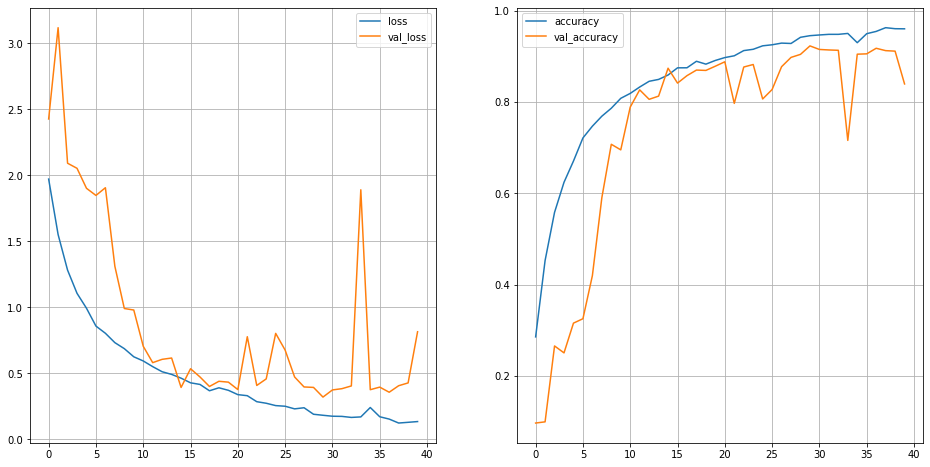

CNN Error: 8.41%


In [ ]:
df_history = pd.DataFrame(history.history)
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

cut_first_n = 0
df_history.loc[cut_first_n:, ['loss', 'val_loss']].plot(ax=ax[0])
df_history.loc[cut_first_n:, ['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].grid(which='both')
ax[1].grid(which='both')
plt.show()

scores = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

## Make Predictions

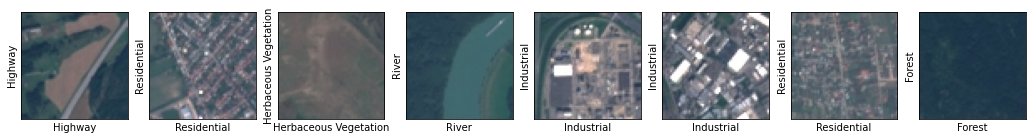

In [ ]:
labels = ['Annual Crop', 'Forest', 'Herbaceous Vegetation', 'Highway', 'Industrial', 'Pasture', 'Permanent Crop', 'Residential', 'River', 'SeaLake']

N = 8
fig, ax = plt.subplots(1, N, figsize=(18, 4))
predictions = []
for _ in range(N):
  i = random.randint(0, X_test.shape[0])
  predictions.append(np.argmax(model.predict(X_test[i].reshape(1, *X_test[i].shape))))
  ax[len(predictions)-1].imshow(X_test[i])

  ax[len(predictions)-1].set_xlabel(labels[np.argmax(y_test[i])])
  ax[len(predictions)-1].set_xticks([])

  ax[len(predictions)-1].set_ylabel(labels[predictions[-1]])
  ax[len(predictions)-1].set_yticks([])
plt.show()

In [ ]:
np.argmax(y_test[0])

7

# ❓ Your CNN

Write your own CNN architecture and train it on the dataset...

What test error can you reach?